In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_squared_error, r2_score, PredictionErrorDisplay
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth',None)

In [50]:
df = pd.read_csv('../data/raw/train.csv')


# Pre-Proccesing

In [51]:
df = df.rename(columns={
    'Age (years)': 'Age',
    'Income Level': 'Income',
    'Education Level': 'Education',
    'Sun Exposure': 'Sun_Exposure',
    'Pollution Exposure': 'Pollution',
    'Stress Levels': 'Stress',
    'Sleep Patterns': 'Sleep',
    'Mental Health Status': 'Mental_Health',
    'Cognitive Function': 'Cognitive_Function',
    'Family History': 'Family_History',
    'Medication Use': 'Medication',
    'Chronic Diseases': 'Chronic_Diseases',
    'Diet': 'Diet',
    'Alcohol Consumption': 'Alcohol',
    'Smoking Status': 'Smoking',
    'Physical Activity Level': 'Physical_Activity',
    'Hearing Ability (dB)': 'Hearing',
    'Vision Sharpness': 'Vision',
    'Bone Density (g/cm²)': 'Bone_Density',
    'Blood Glucose Level (mg/dL)': 'Blood_Glucose',
    'BMI': 'BMI',
    'Cholesterol Level (mg/dL)': 'Cholesterol',
    'Blood Pressure (s/d)': 'Blood_Pressure',
    'Weight (kg)': 'Weight',
    'Height (cm)': 'Height',
    'Gender': 'Gender'
})


In [52]:
bp_split = df['Blood_Pressure'].str.split('/', expand=True)
df['Systolic_BP'] = pd.to_numeric(bp_split[0])
df['Diastolic_BP'] = pd.to_numeric(bp_split[1])

# Drop the original "Blood Pressure (s/d)" column
df.drop(columns=['Blood_Pressure'], inplace=True)

In [53]:
df.head(5)

,Gender,Height,Weight,Cholesterol,BMI,Blood_Glucose,Bone_Density,Vision,Hearing,Physical_Activity,Smoking,Alcohol,Diet,Chronic_Diseases,Medication,Family_History,Cognitive_Function,Mental_Health,Sleep,Stress,Pollution,Sun_Exposure,Education,Income,Age,Systolic_BP,Diastolic_BP
0,Male,171.148359,86.185197,259.465814,29.423017,157.652848,0.132868,0.200000,58.786198,Moderate,Former,NaN,Low-carb,NaN,NaN,NaN,44.059172,Good,Insomnia,2.797064,5.142344,7.108975,NaN,Medium,89,151,109
1,Male,172.946206,79.641937,263.630292,26.626847,118.507805,0.629534,0.267312,54.635270,Low,Current,Occasional,Balanced,Hypertension,NaN,Heart Disease,45.312298,Good,Normal,9.339930,7.272720,3.918489,Undergraduate,Medium,77,134,112
2,Female,155.945488,49.167058,207.846206,20.217553,143.587550,0.473487,0.248667,54.564632,Moderate,Never,NaN,Balanced,Hypertension,Regular,Hypertension,56.246991,Poor,Insomnia,9.234637,8.500386,5.393408,NaN,Medium,70,160,101
3,Female,169.078298,56.017921,253.283779,19.595270,137.448581,1.184315,0.513818,79.722963,Moderate,Never,NaN,Balanced,Diabetes,Occasional,Hypertension,55.196092,Poor,Insomnia,4.693446,7.555511,2.745578,NaN,Low,52,133,94
4,Female,163.758355,73.966304,236.119899,27.582078,145.328695,0.434562,0.306864,52.479469,Low,Former,Frequent,Vegetarian,NaN,NaN,NaN,53.023379,Good,Normal,4.038537,9.429097,3.878435,Undergraduate,High,79,170,106


In [54]:
df.isnull().sum()

Gender                   0
Height                   0
Weight                   0
Cholesterol              0
BMI                      0
Blood_Glucose            0
Bone_Density             0
Vision                   0
Hearing                  0
Physical_Activity        0
Smoking                  0
Alcohol               1201
Diet                     0
Chronic_Diseases      1299
Medication            1198
Family_History        1451
Cognitive_Function       0
Mental_Health            0
Sleep                    0
Stress                   0
Pollution                0
Sun_Exposure             0
Education              627
Income                   0
Age                      0
Systolic_BP              0
Diastolic_BP             0
dtype: int64

## Xử lý giá trị null bằng phương pháp KNN

### Chuẩn hóa các biến phân loại

In [55]:
encoded_data = df
encoders = {}
for col in encoded_data.columns:
    if encoded_data[col].dtype == 'object' or encoded_data[col].isnull().any():
        encoder = preprocessing.LabelEncoder()
        encoded_data[col] = pd.Series(
            encoder.fit_transform(encoded_data[col][encoded_data[col].notnull()]),
            index=encoded_data[col][encoded_data[col].notnull()].index)
        encoders[col] = encoder 

In [56]:
encoded_data.head()

,Gender,Height,Weight,Cholesterol,BMI,Blood_Glucose,Bone_Density,Vision,Hearing,Physical_Activity,Smoking,Alcohol,Diet,Chronic_Diseases,Medication,Family_History,Cognitive_Function,Mental_Health,Sleep,Stress,Pollution,Sun_Exposure,Education,Income,Age,Systolic_BP,Diastolic_BP
0,1,171.148359,86.185197,259.465814,29.423017,157.652848,0.132868,0.200000,58.786198,2,1,NaN,2,NaN,NaN,NaN,44.059172,2,1,2.797064,5.142344,7.108975,NaN,2,89,151,109
1,1,172.946206,79.641937,263.630292,26.626847,118.507805,0.629534,0.267312,54.635270,1,0,1.0,0,2.0,NaN,1.0,45.312298,2,2,9.339930,7.272720,3.918489,2.0,2,77,134,112
2,0,155.945488,49.167058,207.846206,20.217553,143.587550,0.473487,0.248667,54.564632,2,2,NaN,0,2.0,1.0,2.0,56.246991,3,1,9.234637,8.500386,5.393408,NaN,2,70,160,101
3,0,169.078298,56.017921,253.283779,19.595270,137.448581,1.184315,0.513818,79.722963,2,2,NaN,0,0.0,0.0,2.0,55.196092,3,1,4.693446,7.555511,2.745578,NaN,1,52,133,94
4,0,163.758355,73.966304,236.119899,27.582078,145.328695,0.434562,0.306864,52.479469,1,1,0.0,3,NaN,NaN,NaN,53.023379,2,2,4.038537,9.429097,3.878435,2.0,0,79,170,106


In [57]:
imputer = KNNImputer(n_neighbors=15)
imputed_data = pd.DataFrame(imputer.fit_transform(encoded_data), columns=encoded_data.columns)

In [58]:
imputed_data.head()

,Gender,Height,Weight,Cholesterol,BMI,Blood_Glucose,Bone_Density,Vision,Hearing,Physical_Activity,Smoking,Alcohol,Diet,Chronic_Diseases,Medication,Family_History,Cognitive_Function,Mental_Health,Sleep,Stress,Pollution,Sun_Exposure,Education,Income,Age,Systolic_BP,Diastolic_BP
0,1.0,171.148359,86.185197,259.465814,29.423017,157.652848,0.132868,0.200000,58.786198,2.0,1.0,0.666667,2.0,1.333333,0.733333,0.866667,44.059172,2.0,1.0,2.797064,5.142344,7.108975,0.733333,2.0,89.0,151.0,109.0
1,1.0,172.946206,79.641937,263.630292,26.626847,118.507805,0.629534,0.267312,54.635270,1.0,0.0,1.000000,0.0,2.000000,0.666667,1.000000,45.312298,2.0,2.0,9.339930,7.272720,3.918489,2.000000,2.0,77.0,134.0,112.0
2,0.0,155.945488,49.167058,207.846206,20.217553,143.587550,0.473487,0.248667,54.564632,2.0,2.0,0.733333,0.0,2.000000,1.000000,2.000000,56.246991,3.0,1.0,9.234637,8.500386,5.393408,0.733333,2.0,70.0,160.0,101.0
3,0.0,169.078298,56.017921,253.283779,19.595270,137.448581,1.184315,0.513818,79.722963,2.0,2.0,0.600000,0.0,0.000000,0.000000,2.000000,55.196092,3.0,1.0,4.693446,7.555511,2.745578,0.866667,1.0,52.0,133.0,94.0
4,0.0,163.758355,73.966304,236.119899,27.582078,145.328695,0.434562,0.306864,52.479469,1.0,1.0,0.000000,3.0,1.333333,0.466667,1.133333,53.023379,2.0,2.0,4.038537,9.429097,3.878435,2.000000,0.0,79.0,170.0,106.0


In [59]:
decoded_data = imputed_data.copy()
for col, encoder in encoders.items():
    decoded_data[col] = pd.Series(
        encoder.inverse_transform(decoded_data[col].round().astype(int)),
        index=decoded_data.index
    )

In [60]:
decoded_data.head(5)

,Gender,Height,Weight,Cholesterol,BMI,Blood_Glucose,Bone_Density,Vision,Hearing,Physical_Activity,Smoking,Alcohol,Diet,Chronic_Diseases,Medication,Family_History,Cognitive_Function,Mental_Health,Sleep,Stress,Pollution,Sun_Exposure,Education,Income,Age,Systolic_BP,Diastolic_BP
0,Male,171.148359,86.185197,259.465814,29.423017,157.652848,0.132868,0.200000,58.786198,Moderate,Former,Occasional,Low-carb,Heart Disease,Regular,Heart Disease,44.059172,Good,Insomnia,2.797064,5.142344,7.108975,Postgraduate,Medium,89.0,151.0,109.0
1,Male,172.946206,79.641937,263.630292,26.626847,118.507805,0.629534,0.267312,54.635270,Low,Current,Occasional,Balanced,Hypertension,Regular,Heart Disease,45.312298,Good,Normal,9.339930,7.272720,3.918489,Undergraduate,Medium,77.0,134.0,112.0
2,Female,155.945488,49.167058,207.846206,20.217553,143.587550,0.473487,0.248667,54.564632,Moderate,Never,Occasional,Balanced,Hypertension,Regular,Hypertension,56.246991,Poor,Insomnia,9.234637,8.500386,5.393408,Postgraduate,Medium,70.0,160.0,101.0
3,Female,169.078298,56.017921,253.283779,19.595270,137.448581,1.184315,0.513818,79.722963,Moderate,Never,Occasional,Balanced,Diabetes,Occasional,Hypertension,55.196092,Poor,Insomnia,4.693446,7.555511,2.745578,Postgraduate,Low,52.0,133.0,94.0
4,Female,163.758355,73.966304,236.119899,27.582078,145.328695,0.434562,0.306864,52.479469,Low,Former,Frequent,Vegetarian,Heart Disease,Occasional,Heart Disease,53.023379,Good,Normal,4.038537,9.429097,3.878435,Undergraduate,High,79.0,170.0,106.0


In [61]:
decoded_data['Physical_Activity'].unique()

array(['Moderate', 'Low', 'High'], dtype=object)

## Xử lý các Outliers

In [62]:
categorical_features = decoded_data.select_dtypes(include=['object', 'category']).columns
numeric_columns = decoded_data.select_dtypes(include=['number']).columns

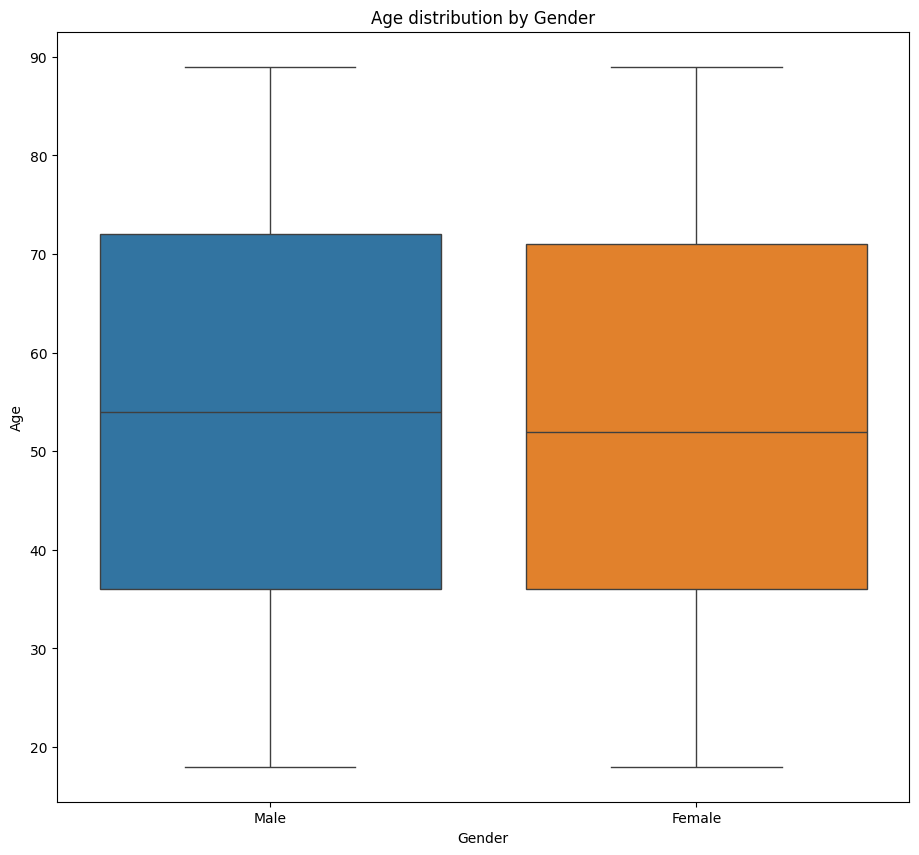

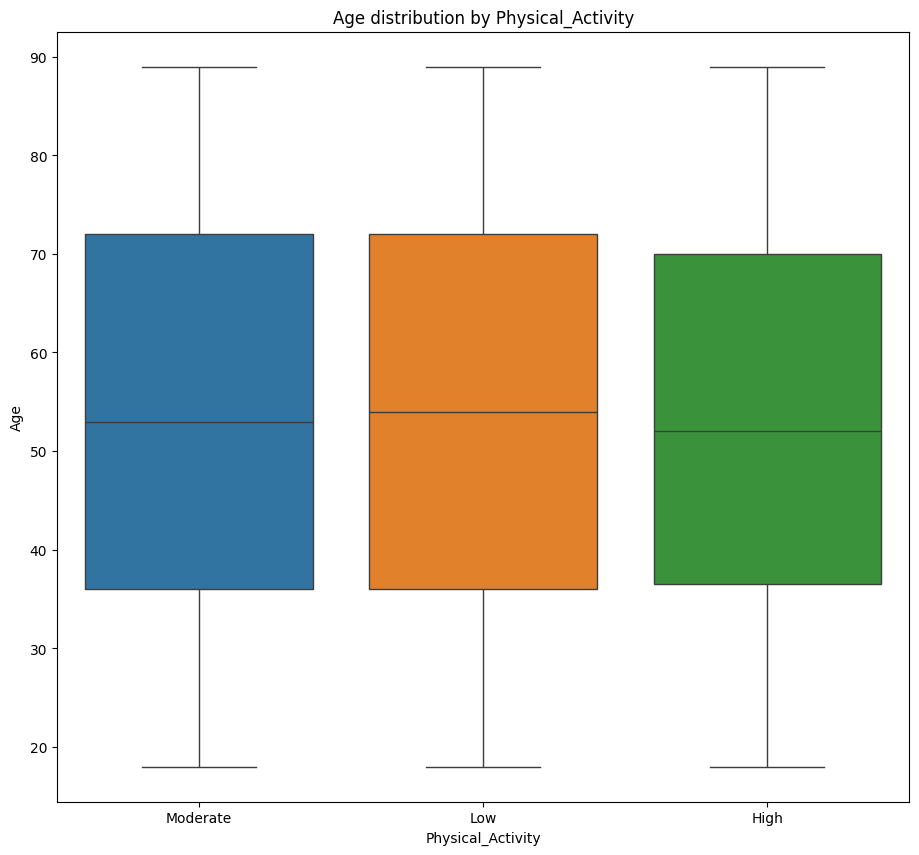

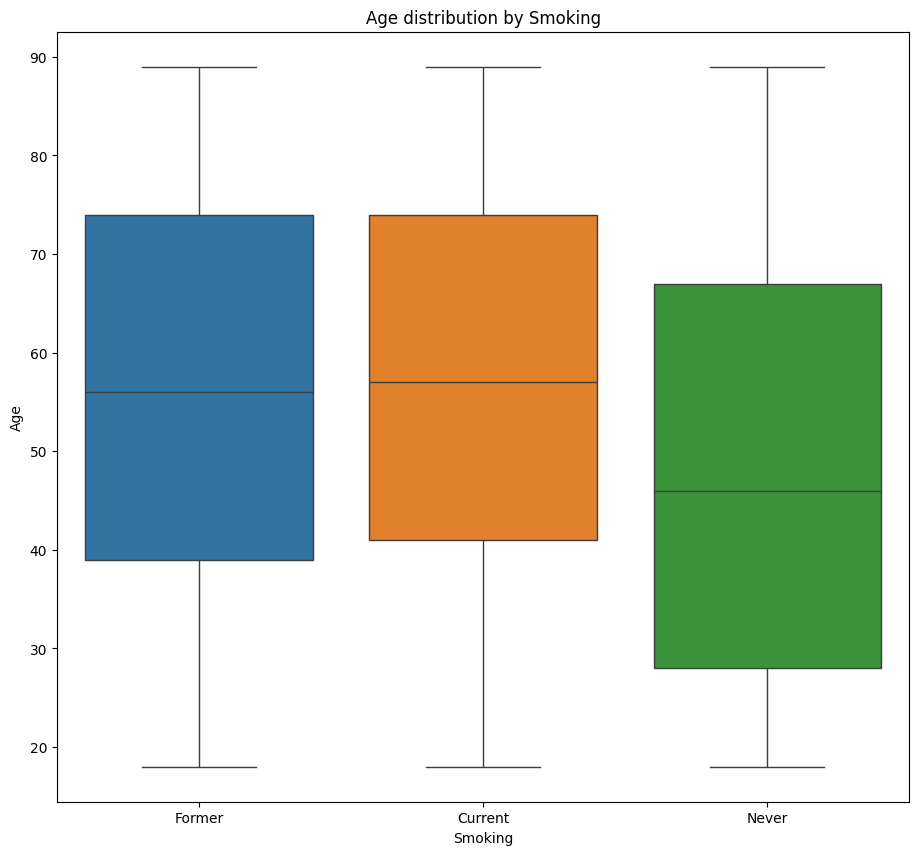

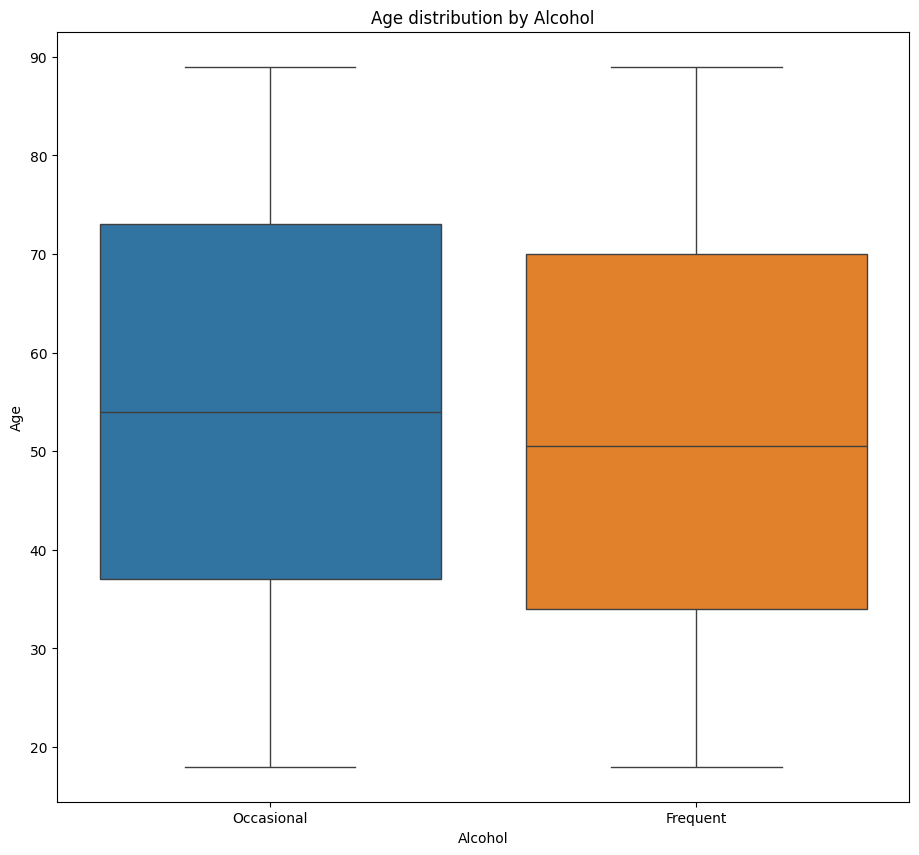

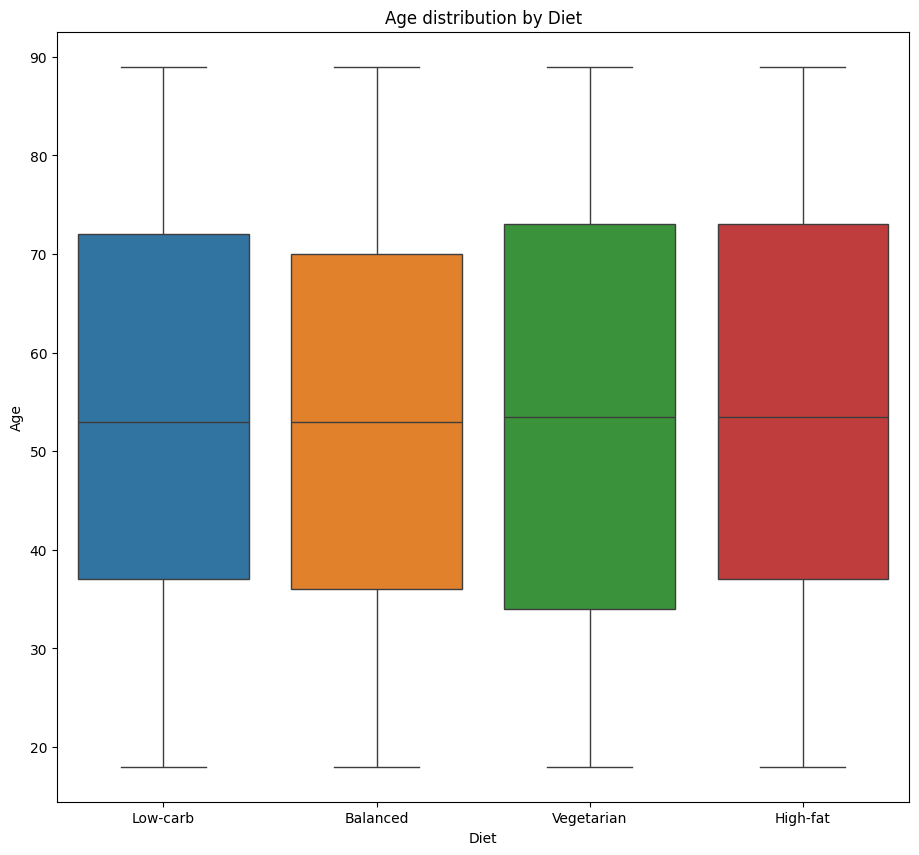

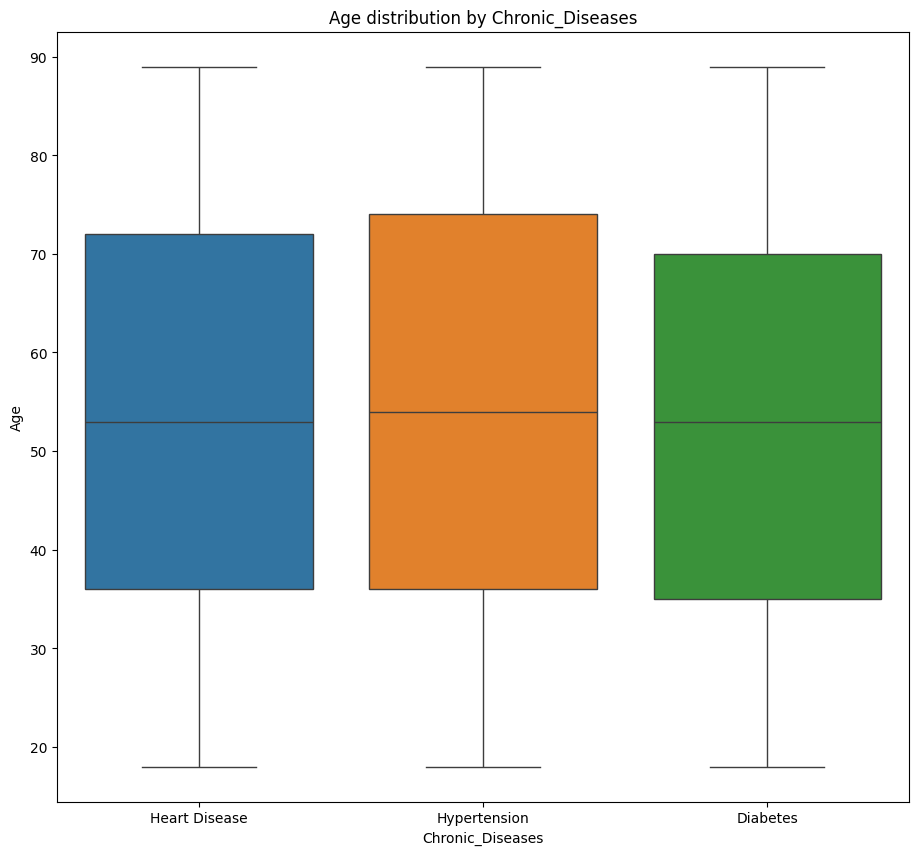

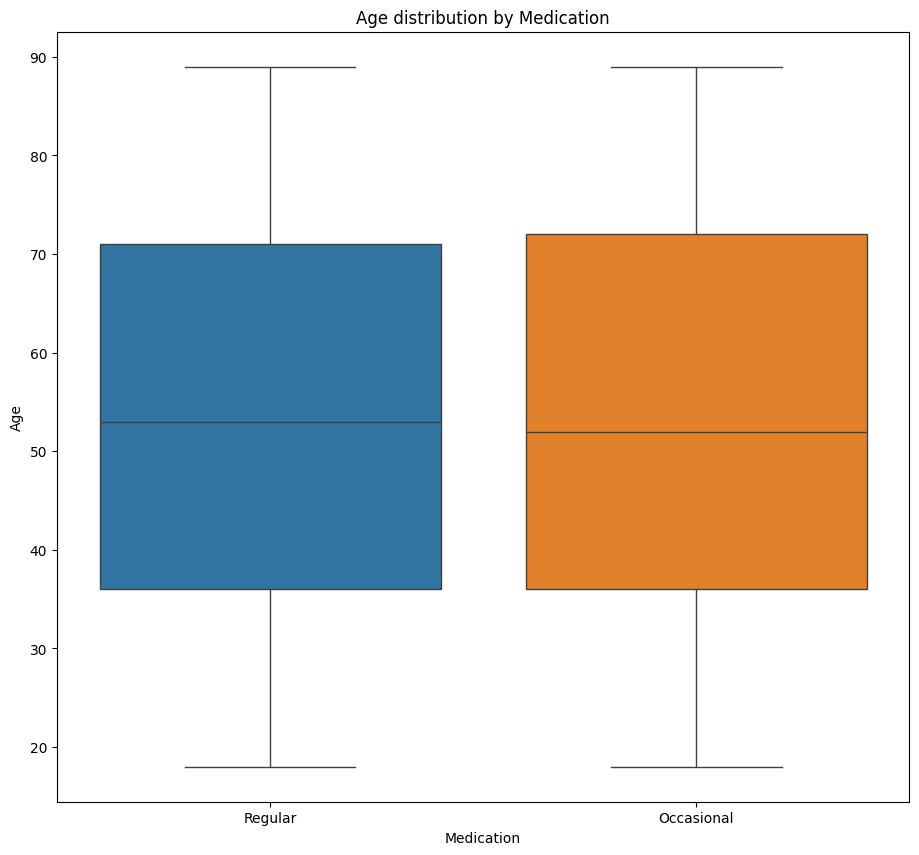

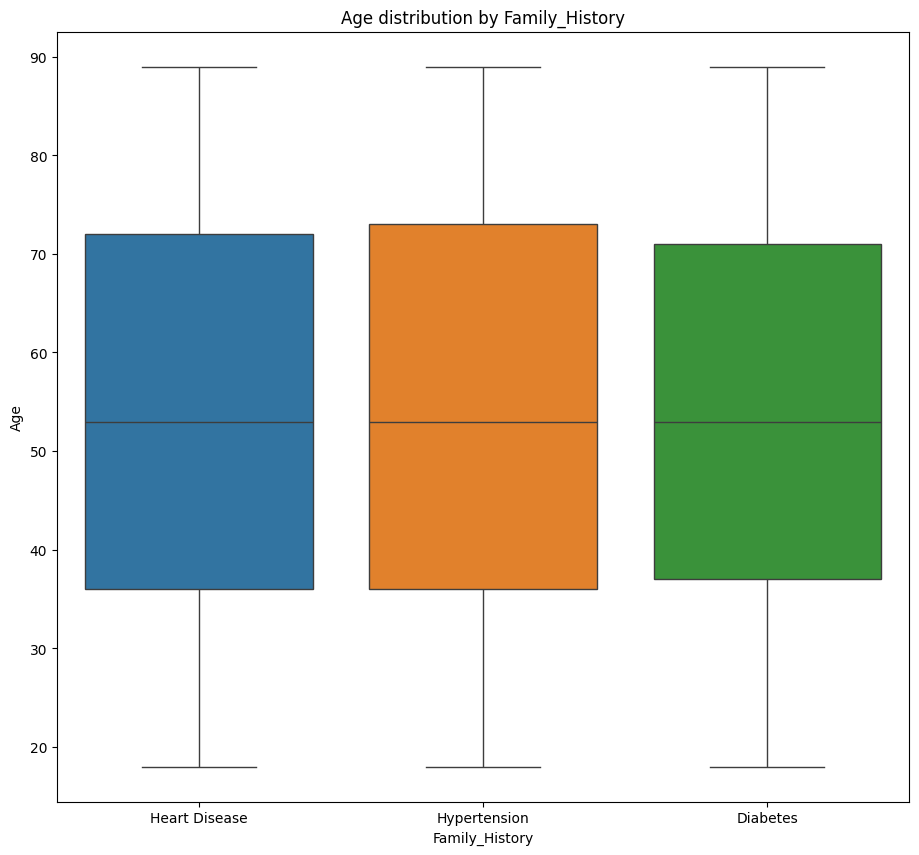

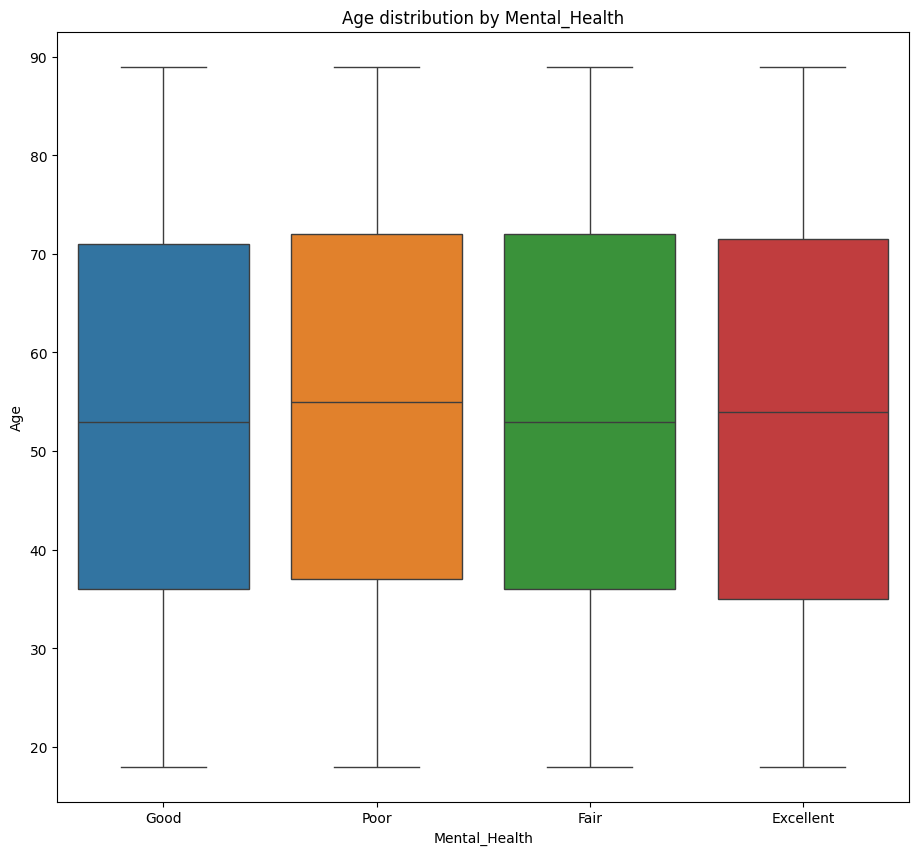

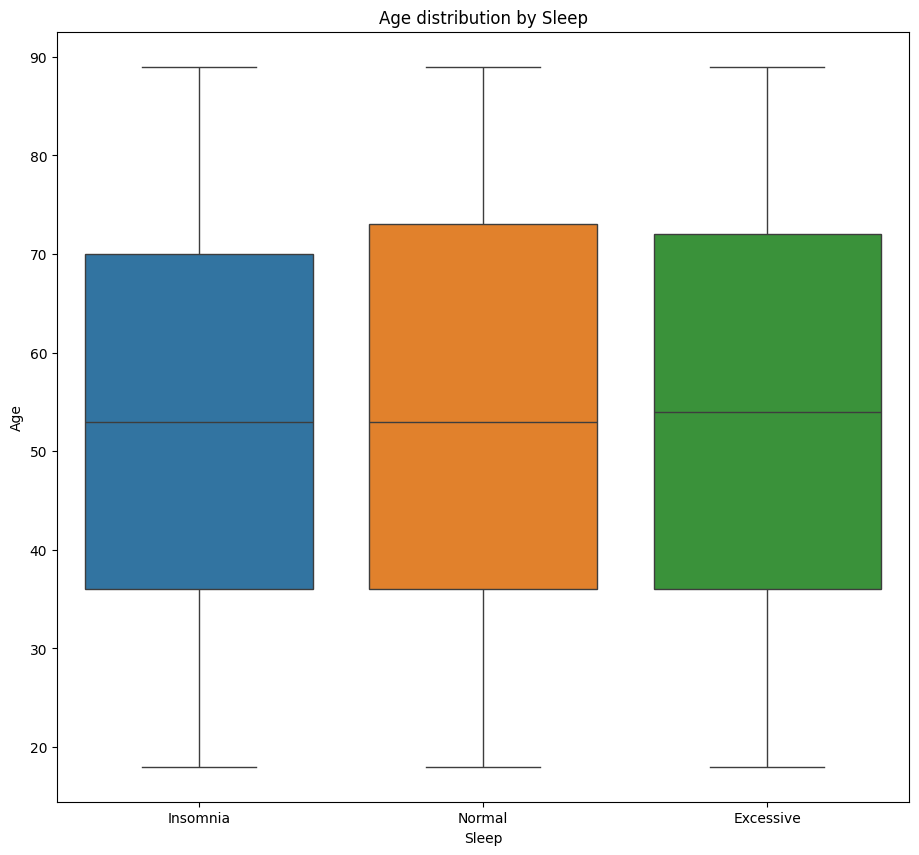

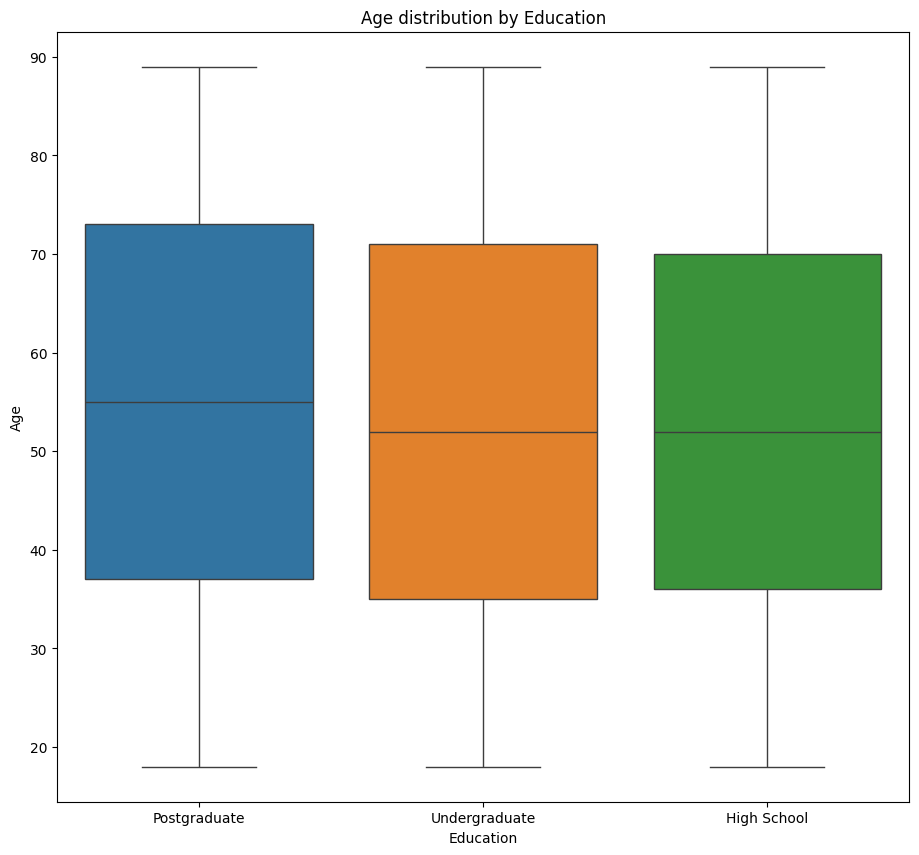

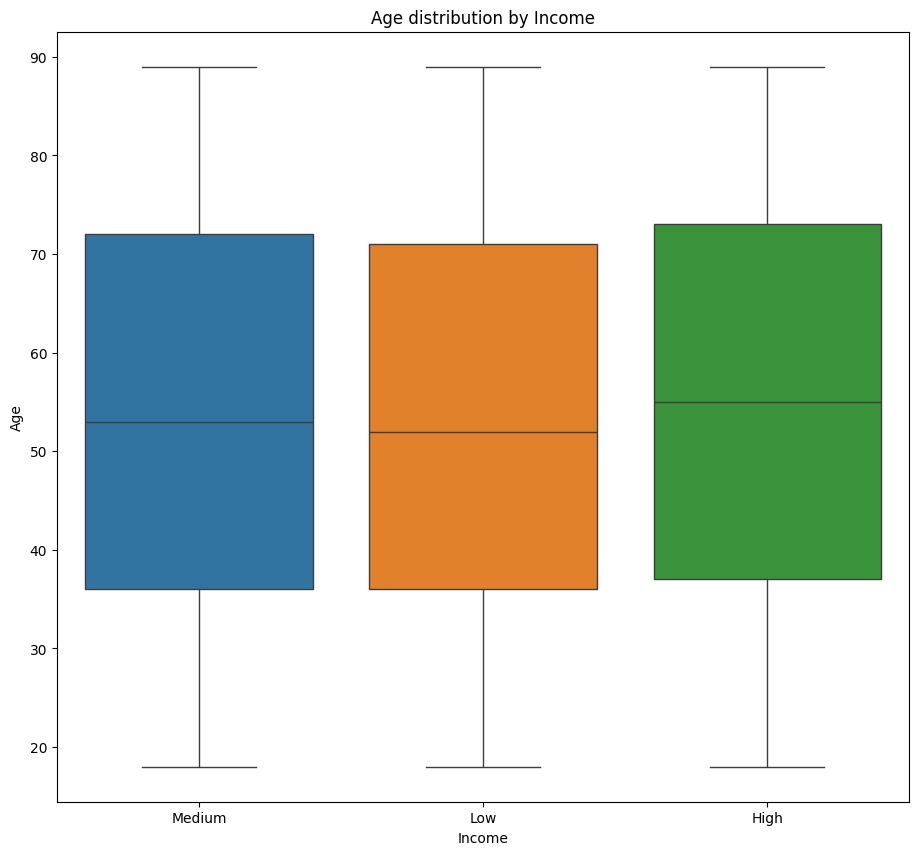

In [63]:
for category in categorical_features:
    f, ax = plt.subplots(figsize=(11,10))
    plt.title(f'Age distribution by {category}')
    sns.boxplot(data=decoded_data, y='Age', x=category, hue=category)
    plt.show()
    plt.close()   

C:\Users\DELL.DESKTOP-QUFQM0F\AppData\Local\Temp\ipykernel_14960\2591272135.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([imputed_data[col] for col in numeric_columns], labels=numeric_columns)


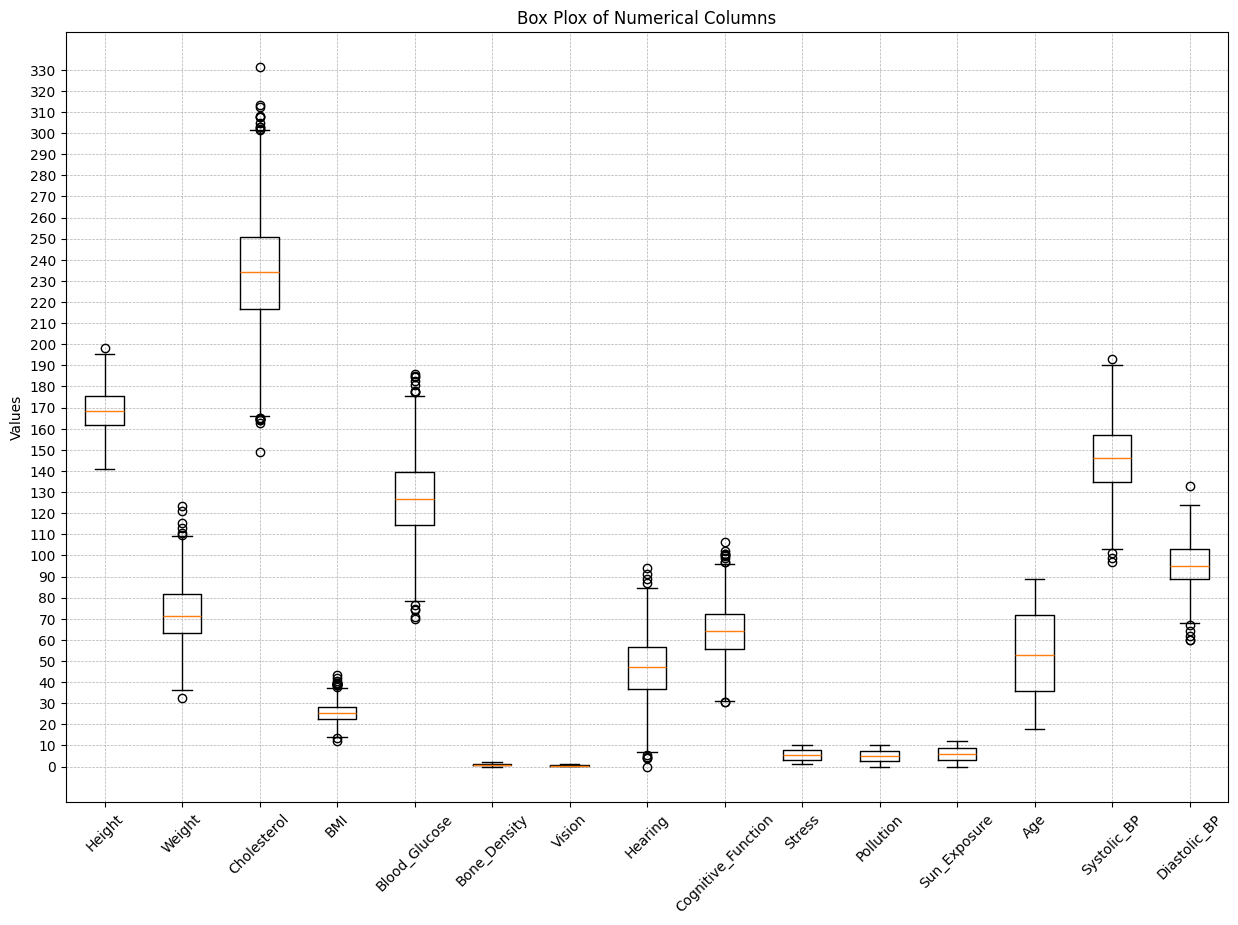

In [64]:
plt.figure(figsize=(15,10))
plt.boxplot([imputed_data[col] for col in numeric_columns], labels=numeric_columns)
plt.title("Box Plox of Numerical Columns")
plt.xticks(rotation=45)
plt.ylabel("Values")
plt.grid(linestyle="--", linewidth=0.5)
plt.yticks(range(int(imputed_data[numeric_columns].min().min()), int(imputed_data[numeric_columns].max().max())+1,10))
plt.show()

In [65]:
def cap_outliers(data, numeric_columns, factor=1.5):
    capped_data = imputed_data.copy()
    
    for col in numeric_columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        capped_data[col] = data[col].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
        
    return capped_data


data = cap_outliers(imputed_data,numeric_columns,1.5)

C:\Users\DELL.DESKTOP-QUFQM0F\AppData\Local\Temp\ipykernel_14960\3664345581.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data[col] for col in numeric_columns], labels=numeric_columns)


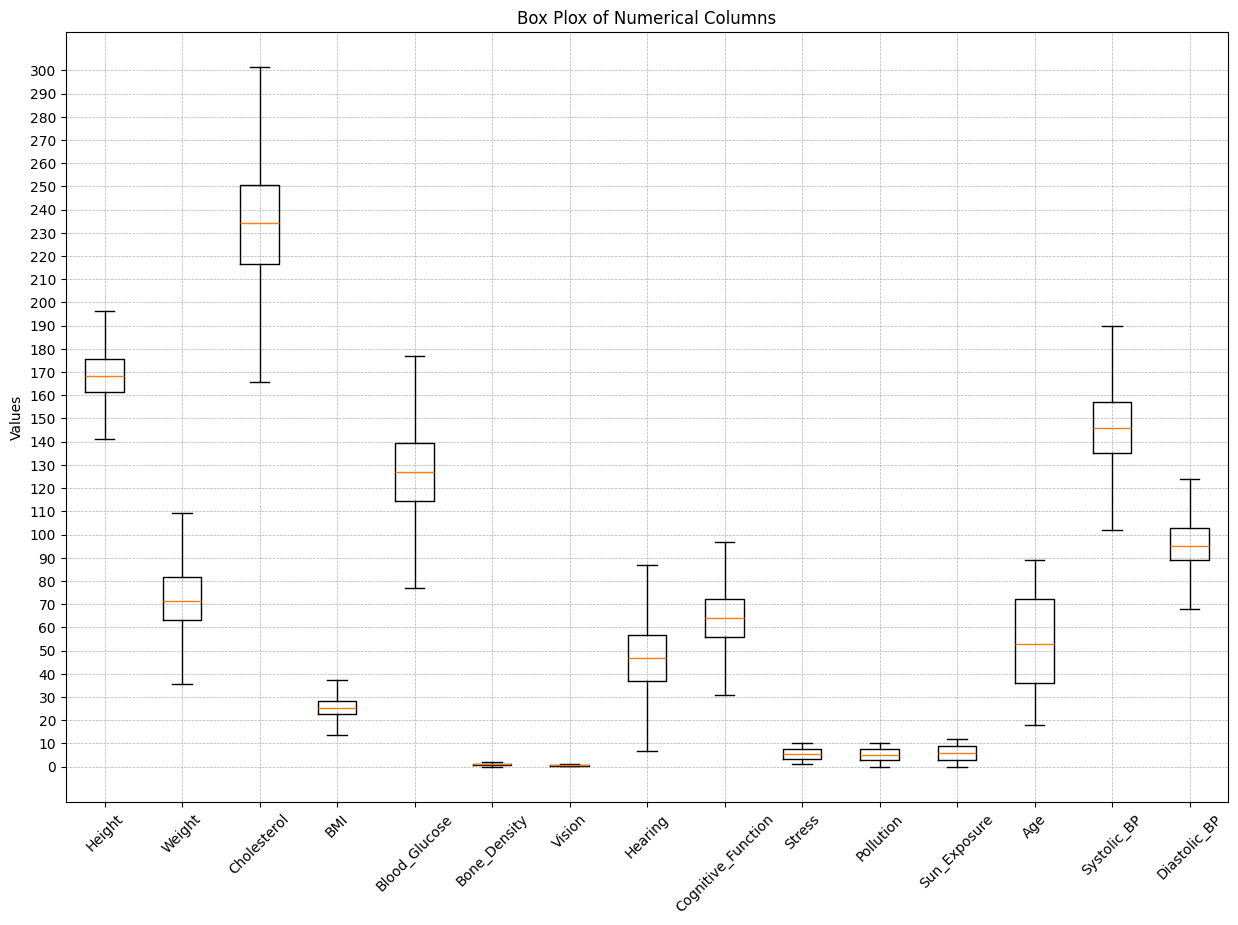

In [66]:
plt.figure(figsize=(15,10))
plt.boxplot([data[col] for col in numeric_columns], labels=numeric_columns)
plt.title("Box Plox of Numerical Columns")
plt.xticks(rotation=45)
plt.ylabel("Values")
plt.grid(linestyle="--", linewidth=0.5)
plt.yticks(range(int(data[numeric_columns].min().min()), int(data[numeric_columns].max().max())+1,10))
plt.show()

In [67]:
data.isnull().sum()

Gender                0
Height                0
Weight                0
Cholesterol           0
BMI                   0
Blood_Glucose         0
Bone_Density          0
Vision                0
Hearing               0
Physical_Activity     0
Smoking               0
Alcohol               0
Diet                  0
Chronic_Diseases      0
Medication            0
Family_History        0
Cognitive_Function    0
Mental_Health         0
Sleep                 0
Stress                0
Pollution             0
Sun_Exposure          0
Education             0
Income                0
Age                   0
Systolic_BP           0
Diastolic_BP          0
dtype: int64

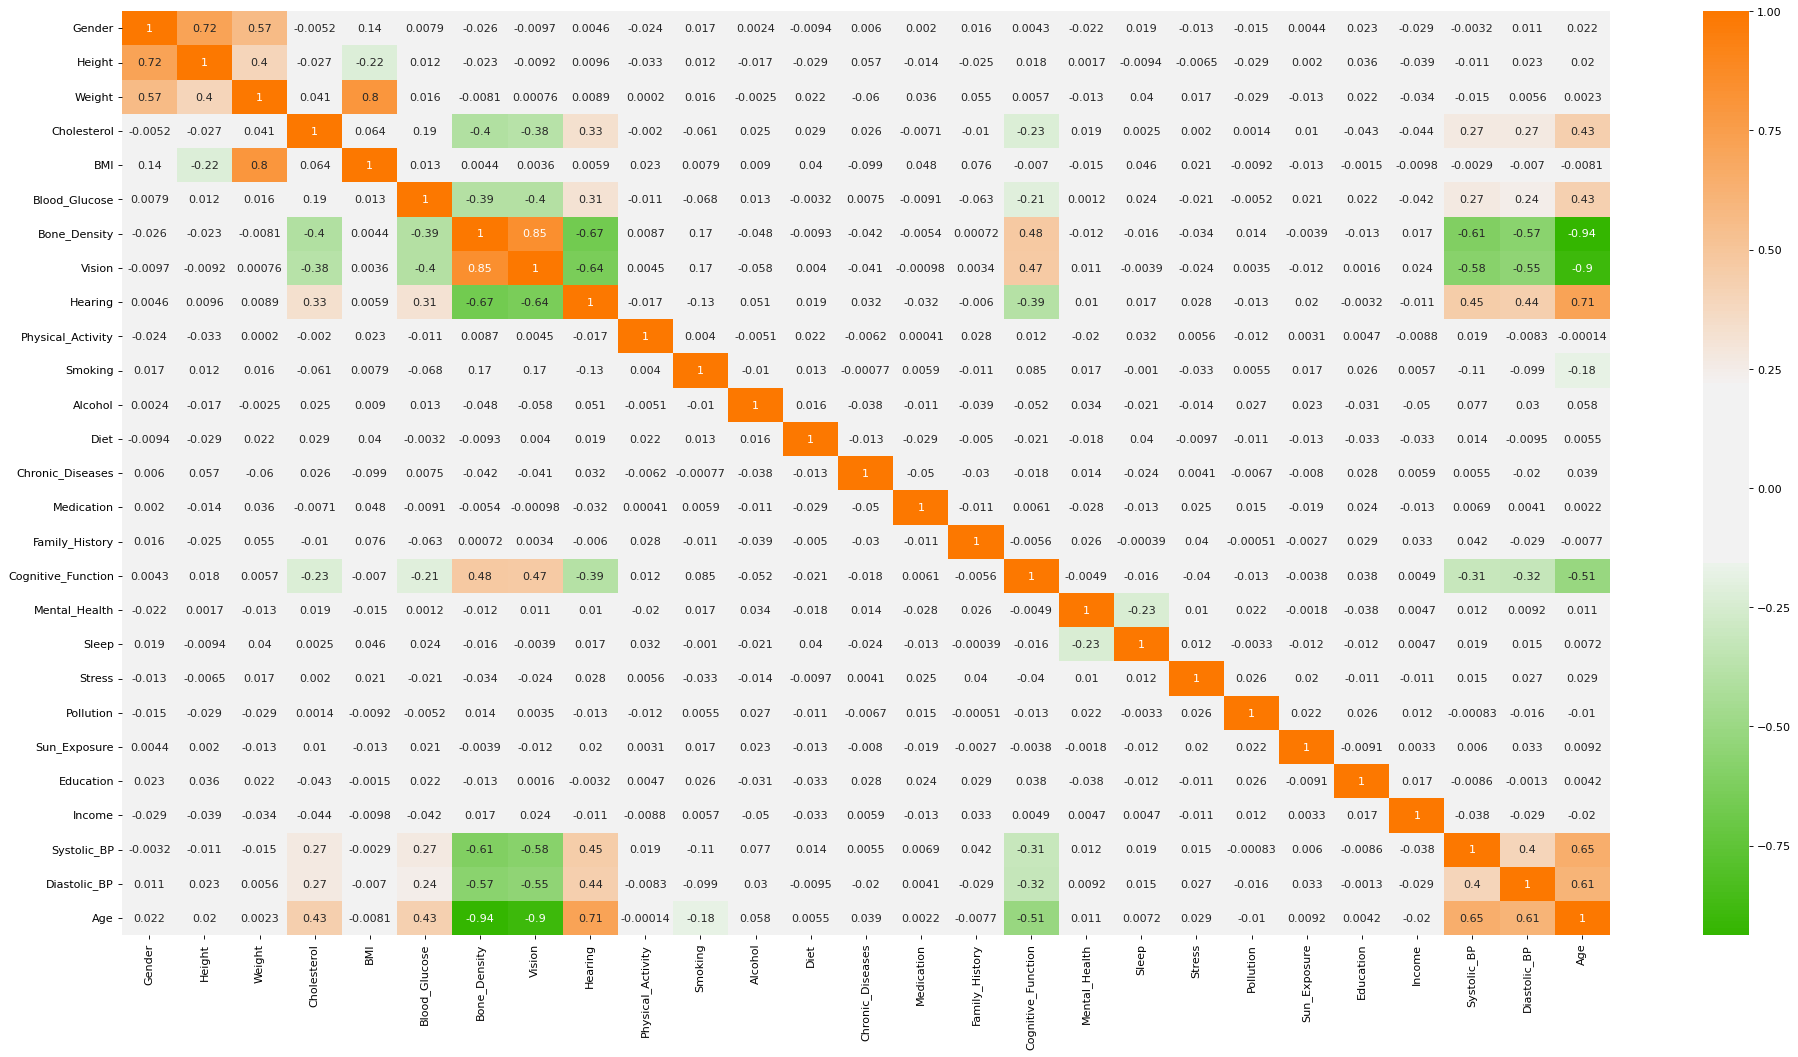

In [68]:
target = 'Age'
cmap = sns.diverging_palette(125, 28, s=100, l=65, sep=50, as_cmap=True)
fig, ax = plt.subplots(figsize=(30, 15), dpi=80)
ax = sns.heatmap(pd.concat([data.drop(target,axis=1), data[target]],axis=1).corr(), annot=True, cmap=cmap)
plt.show()

# Build Model

### Chọn Feature và Target

In [69]:
X = data.drop('Age', axis=1)
y = data['Age']

### Chia tập dữ liệu 80% train và 20% test

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=0)

print("Train set: ", X_train.shape, y_train.shape)
print("Test set: ", X_test.shape, y_test.shape)

Train set:  (2400, 26) (2400,)
Test set:  (600, 26) (600,)


### Train model

In [71]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [72]:
y_pred = model.predict(X_test)
y_pred.round()

array([40., 85., 65., 21., 61., 43., 79., 74., 51., 40., 33., 62., 51.,
       87., 31., 26., 25., 54., 74., 54., 33., 56., 34., 76., 61., 16.,
       41., 83., 64., 33., 62., 74., 40., 26., 67., 21., 53., 30., 44.,
       83., 33., 42., 38., 87., 82., 48., 37., 44., 51., 31., 46., 77.,
       51., 22., 37., 72., 78., 82., 25., 45., 52., 80., 71., 14., 16.,
       43., 73., 79., 27., 30., 41., 51., 82., 75., 69., 52., 43., 30.,
       82., 82., 39., 76., 44., 69., 50., 18., 78., 66., 38., 52., 43.,
       27., 62., 42., 48., 20., 52., 51., 61., 42., 29., 75., 66., 28.,
       68., 16., 68., 36., 59., 59., 46., 84., 72., 65., 51., 60., 79.,
       44., 50., 18., 36., 39., 53., 60., 72., 47., 20., 83., 45., 24.,
       48., 45., 40., 58., 49., 23., 68., 61., 80., 22., 48., 78., 37.,
       73., 68., 27., 74., 65., 85., 41., 68., 21., 41., 84., 49., 51.,
       64., 53., 79., 27., 50., 44., 47., 76., 35., 52., 59., 29., 52.,
       30., 79., 68., 46., 76., 68., 42., 42., 46., 27., 64., 27

In [73]:
y_test

311     45.0
1025    89.0
1587    60.0
2941    22.0
2980    71.0
2078    44.0
2281    78.0
720     78.0
1537    45.0
2493    41.0
1716    28.0
536     66.0
298     48.0
104     86.0
1649    36.0
2299    20.0
1109    29.0
899     52.0
461     81.0
2590    61.0
2664    23.0
983     62.0
1191    39.0
1003    78.0
2692    66.0
463     26.0
1108    50.0
305     86.0
1014    66.0
22      35.0
2770    63.0
1768    71.0
2277    42.0
1027    42.0
1476    80.0
762     20.0
30      62.0
1464    23.0
2132    53.0
1788    77.0
1410    27.0
977     46.0
961     38.0
306     81.0
569     80.0
156     52.0
2850    38.0
1244    46.0
2126    48.0
599     29.0
1351    46.0
1230    76.0
638     51.0
2053    19.0
615     34.0
2925    73.0
2160    88.0
722     89.0
2461    23.0
2460    36.0
2397    47.0
2785    88.0
2561    81.0
503     21.0
2083    18.0
905     46.0
1530    69.0
92      84.0
2411    25.0
1872    28.0
1999    43.0
1330    51.0
1255    88.0
2704    69.0
1217    70.0
898     58.0
483     44.0

# Evaluate model

## Mectrics

In [74]:
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean squared error(MSE): ",mse)
print("Root mean squared error: ", rmse)
print("Mean absolute error: ", mae)
print("R2 score: ", r2)

Mean squared error(MSE):  26.85935002829278
Root mean squared error:  5.18260070122065
Mean absolute error:  4.098010174923358
R2 score:  0.9407756457077734


## Kedplot

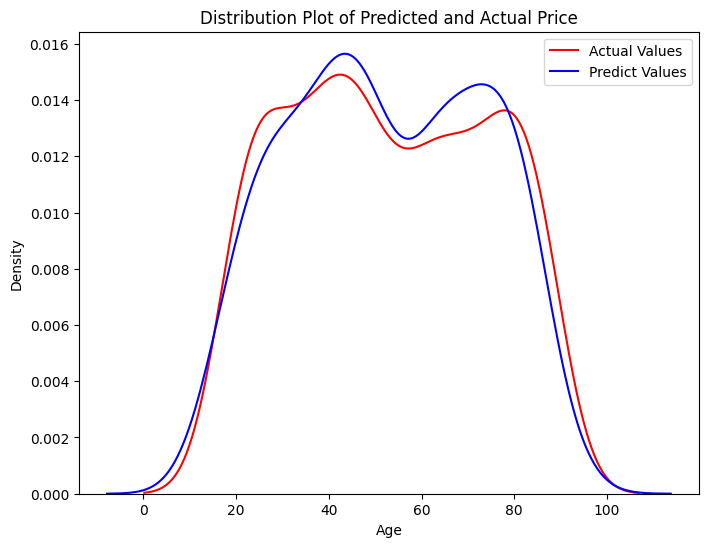

In [75]:
plt.figure(figsize=(8,6))
sns.kdeplot(y_test, color='red', label='Actual Values')
sns.kdeplot(y_pred, color='blue', label = 'Predict Values')
plt.title('Distribution Plot of Predicted and Actual Price')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()

## PredictionErrorDisplay

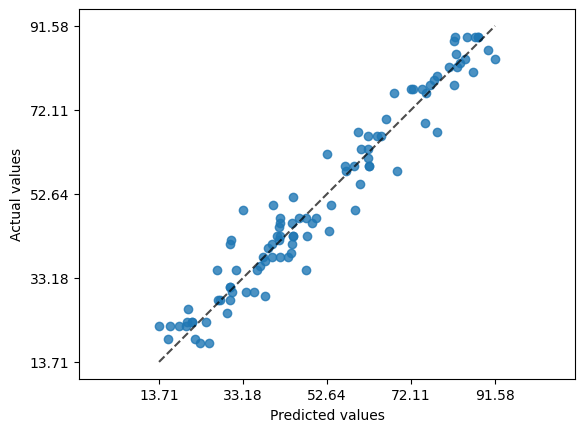

In [48]:

display = PredictionErrorDisplay.from_predictions(y_test,
                                                  y_pred, 
                                                  kind="actual_vs_predicted",
                                                  subsample=100,
                                                  random_state=0)
plt.show()

## K-Fold Cross-Validation

In [114]:
k = 5
kf = KFold(n_splits=5, shuffle=True, random_state=0)
mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_root_mean_squared_error')
mae_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error')
r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

In [115]:
mse_scores = pd.DataFrame(mse_scores*-1, columns=['MSE'])
rmse_scores = pd.DataFrame(rmse_scores*-1, columns=['RMSE'])
mae_scores = pd.DataFrame(mae_scores*-1, columns=['MAE'])
r2_scores = pd.DataFrame(r2_scores, columns=['R2'])
score = pd.concat([mse_scores, rmse_scores, mae_scores, r2_scores], axis=1)
score

,MSE,RMSE,MAE,R2
0,26.859350,5.182601,4.098010,0.940776
1,26.078300,5.106692,4.065041,0.936521
2,26.725771,5.169697,4.164620,0.938409
3,29.823053,5.461049,4.432076,0.926236
4,26.435300,5.141527,4.111253,0.935707


In [117]:
print(f"Average MSE across {k} folds: {np.mean(mse_scores):.2f}")
print(f"Average RMSE across {k} folds: {np.mean(rmse_scores):.2f}")
print(f"Average MAE across {k} folds: {np.mean(mae_scores):.2f}")
print(f"Average R2 across {k} folds: {np.mean(r2_scores):.2f}")

Average MSE across 5 folds: 27.18
Average RMSE across 5 folds: 5.21
Average MAE across 5 folds: 4.17
Average R2 across 5 folds: 0.94


# Dữ liệu khi điền khuyết bằng mode

In [150]:
data2 = pd.read_csv('../data/interim/handled_missing_values.csv')

In [151]:
data2.head(5)

,Gender,Height,Weight,Cholesterol,BMI,Blood_Glucose,Bone_Density,Vision,Hearing,Physical_Activity,Smoking,Alcohol,Diet,Chronic_Diseases,Medication,Family_History,Cognitive_Function,Mental_Health,Sleep,Stress,Pollution,Sun_Exposure,Education,Income,Age,Systolic_BP,Diastolic_BP
0,Male,171.148359,86.185197,259.465814,29.423017,157.652848,0.132868,0.200000,58.786198,Moderate,Former,Occasional,Low-carb,Hypertension,Regular,Diabetes,44.059172,Good,Insomnia,2.797064,5.142344,7.108975,Undergraduate,Medium,89,151,109
1,Male,172.946206,79.641937,263.630292,26.626847,118.507805,0.629534,0.267312,54.635270,Low,Current,Occasional,Balanced,Hypertension,Regular,Heart Disease,45.312298,Good,Normal,9.339930,7.272720,3.918489,Undergraduate,Medium,77,134,112
2,Female,155.945488,49.167058,207.846206,20.217553,143.587550,0.473487,0.248667,54.564632,Moderate,Never,Occasional,Balanced,Hypertension,Regular,Hypertension,56.246991,Poor,Insomnia,9.234637,8.500386,5.393408,Undergraduate,Medium,70,160,101
3,Female,169.078298,56.017921,253.283779,19.595270,137.448581,1.184315,0.513818,79.722963,Moderate,Never,Occasional,Balanced,Diabetes,Occasional,Hypertension,55.196092,Poor,Insomnia,4.693446,7.555511,2.745578,Undergraduate,Low,52,133,94
4,Female,163.758355,73.966304,236.119899,27.582078,145.328695,0.434562,0.306864,52.479469,Low,Former,Frequent,Vegetarian,Hypertension,Regular,Diabetes,53.023379,Good,Normal,4.038537,9.429097,3.878435,Undergraduate,High,79,170,106


In [152]:
data2.isnull().sum()

Gender                0
Height                0
Weight                0
Cholesterol           0
BMI                   0
Blood_Glucose         0
Bone_Density          0
Vision                0
Hearing               0
Physical_Activity     0
Smoking               0
Alcohol               0
Diet                  0
Chronic_Diseases      0
Medication            0
Family_History        0
Cognitive_Function    0
Mental_Health         0
Sleep                 0
Stress                0
Pollution             0
Sun_Exposure          0
Education             0
Income                0
Age                   0
Systolic_BP           0
Diastolic_BP          0
dtype: int64

In [154]:
encoded_data2 = data2
for col in data.columns:
    if encoded_data2[col].dtype == 'object':
         encoder = preprocessing.LabelEncoder()
         encoded_data2[col] = encoder.fit_transform(data2[col])
encoded_data2.head(5)

,Gender,Height,Weight,Cholesterol,BMI,Blood_Glucose,Bone_Density,Vision,Hearing,Physical_Activity,Smoking,Alcohol,Diet,Chronic_Diseases,Medication,Family_History,Cognitive_Function,Mental_Health,Sleep,Stress,Pollution,Sun_Exposure,Education,Income,Age,Systolic_BP,Diastolic_BP
0,1,171.148359,86.185197,259.465814,29.423017,157.652848,0.132868,0.200000,58.786198,2,1,1,2,2,1,0,44.059172,2,1,2.797064,5.142344,7.108975,2,2,89,151,109
1,1,172.946206,79.641937,263.630292,26.626847,118.507805,0.629534,0.267312,54.635270,1,0,1,0,2,1,1,45.312298,2,2,9.339930,7.272720,3.918489,2,2,77,134,112
2,0,155.945488,49.167058,207.846206,20.217553,143.587550,0.473487,0.248667,54.564632,2,2,1,0,2,1,2,56.246991,3,1,9.234637,8.500386,5.393408,2,2,70,160,101
3,0,169.078298,56.017921,253.283779,19.595270,137.448581,1.184315,0.513818,79.722963,2,2,1,0,0,0,2,55.196092,3,1,4.693446,7.555511,2.745578,2,1,52,133,94
4,0,163.758355,73.966304,236.119899,27.582078,145.328695,0.434562,0.306864,52.479469,1,1,0,3,2,1,0,53.023379,2,2,4.038537,9.429097,3.878435,2,0,79,170,106


In [156]:
categorical_features = data2.select_dtypes(include=['object', 'category']).columns
numeric_columns = data2.select_dtypes(include=['number']).columns

C:\Users\DELL.DESKTOP-QUFQM0F\AppData\Local\Temp\ipykernel_14960\3852606108.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([encoded_data2[col] for col in numeric_columns], labels=numeric_columns)


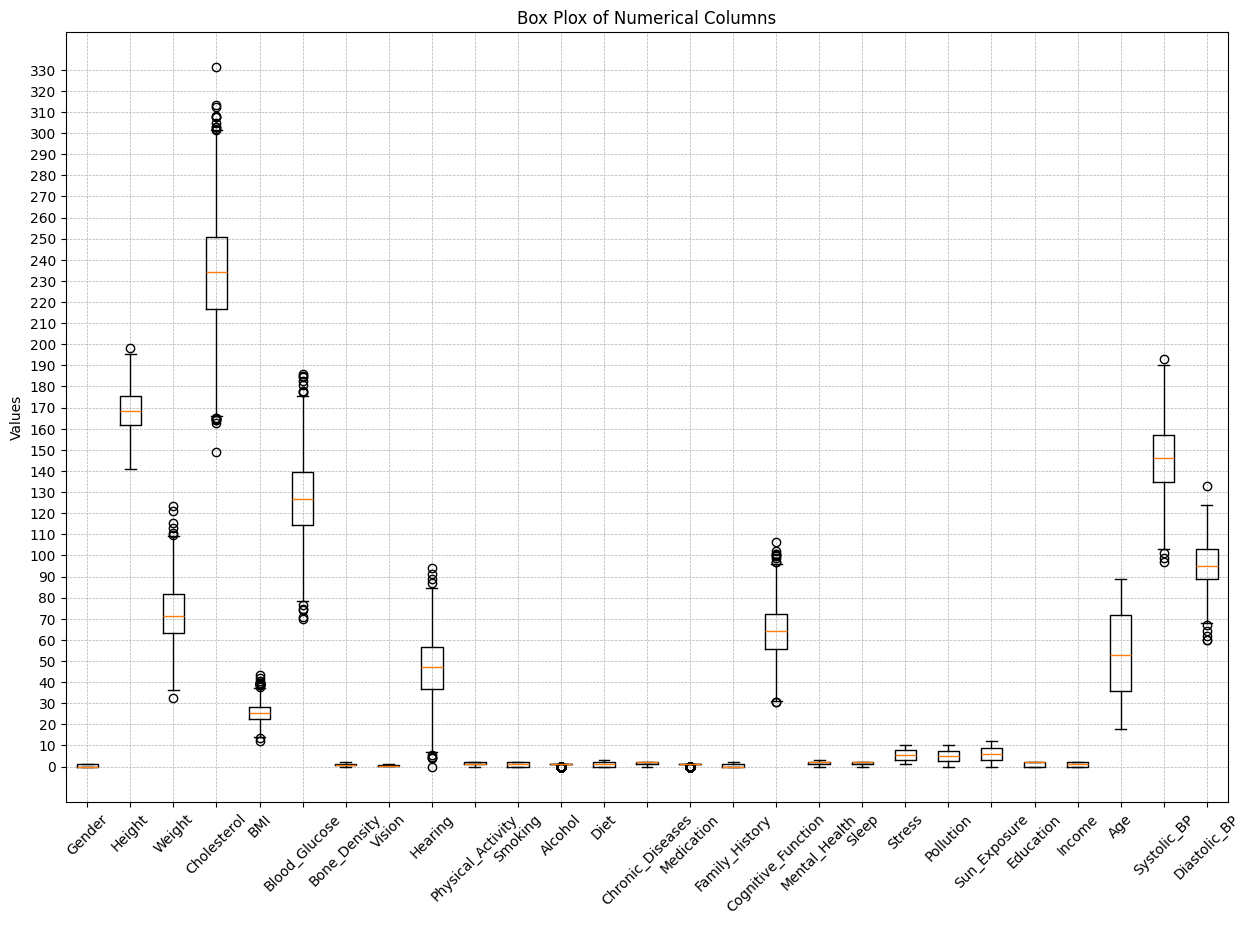

In [157]:
plt.figure(figsize=(15,10))
plt.boxplot([encoded_data2[col] for col in numeric_columns], labels=numeric_columns)
plt.title("Box Plox of Numerical Columns")
plt.xticks(rotation=45)
plt.ylabel("Values")
plt.grid(linestyle="--", linewidth=0.5)
plt.yticks(range(int(encoded_data2[numeric_columns].min().min()), int(encoded_data2[numeric_columns].max().max())+1,10))
plt.show()

In [158]:
def cap_outliers(data, numeric_columns, factor=1.5):
    capped_data = encoded_data2.copy()
    
    for col in numeric_columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        capped_data[col] = data[col].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
        
    return capped_data


data2 = cap_outliers(encoded_data2,numeric_columns,1.5)

C:\Users\DELL.DESKTOP-QUFQM0F\AppData\Local\Temp\ipykernel_14960\154507405.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data2[col] for col in numeric_columns], labels=numeric_columns)


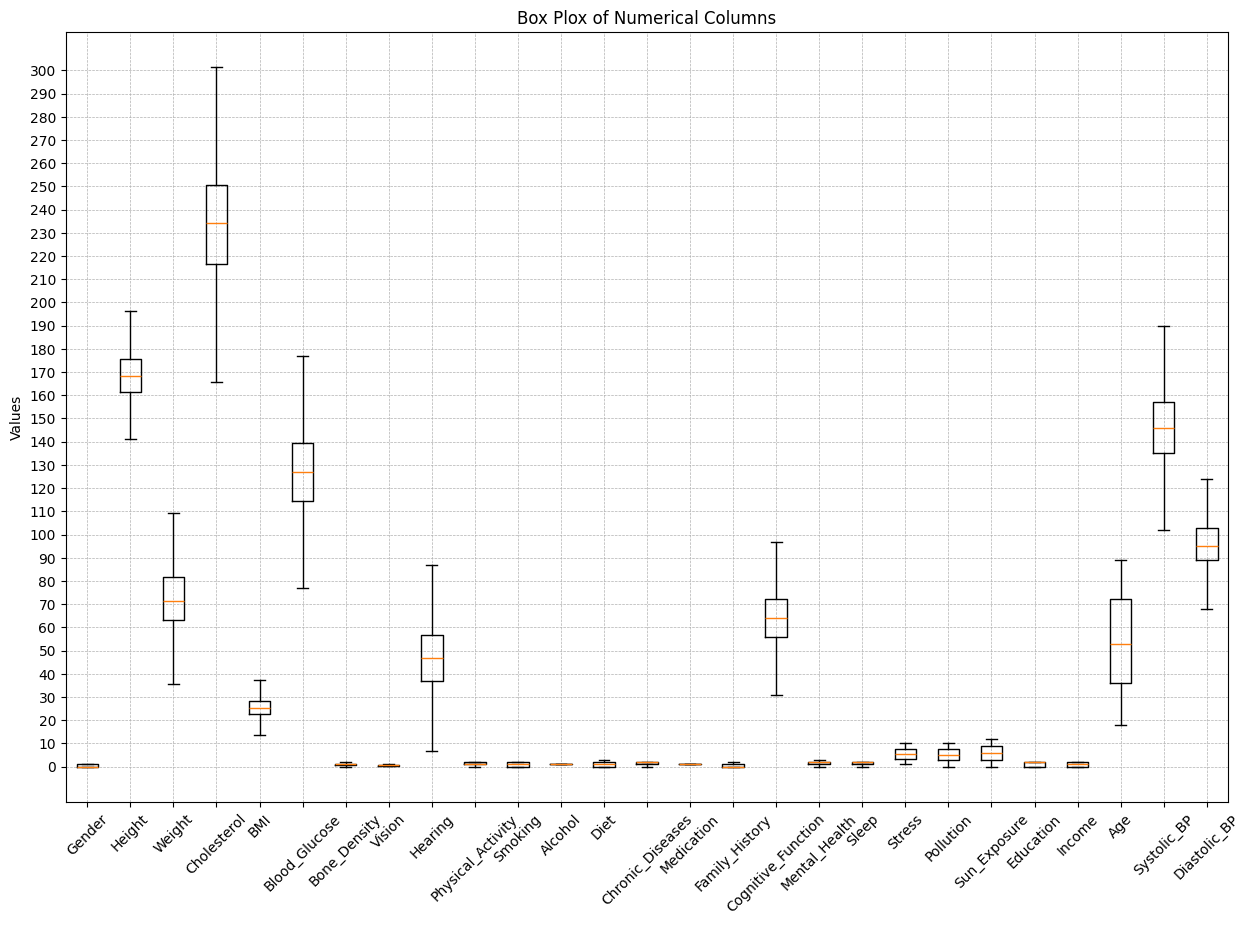

In [159]:
plt.figure(figsize=(15,10))
plt.boxplot([data2[col] for col in numeric_columns], labels=numeric_columns)
plt.title("Box Plox of Numerical Columns")
plt.xticks(rotation=45)
plt.ylabel("Values")
plt.grid(linestyle="--", linewidth=0.5)
plt.yticks(range(int(data2[numeric_columns].min().min()), int(data2[numeric_columns].max().max())+1,10))
plt.show()

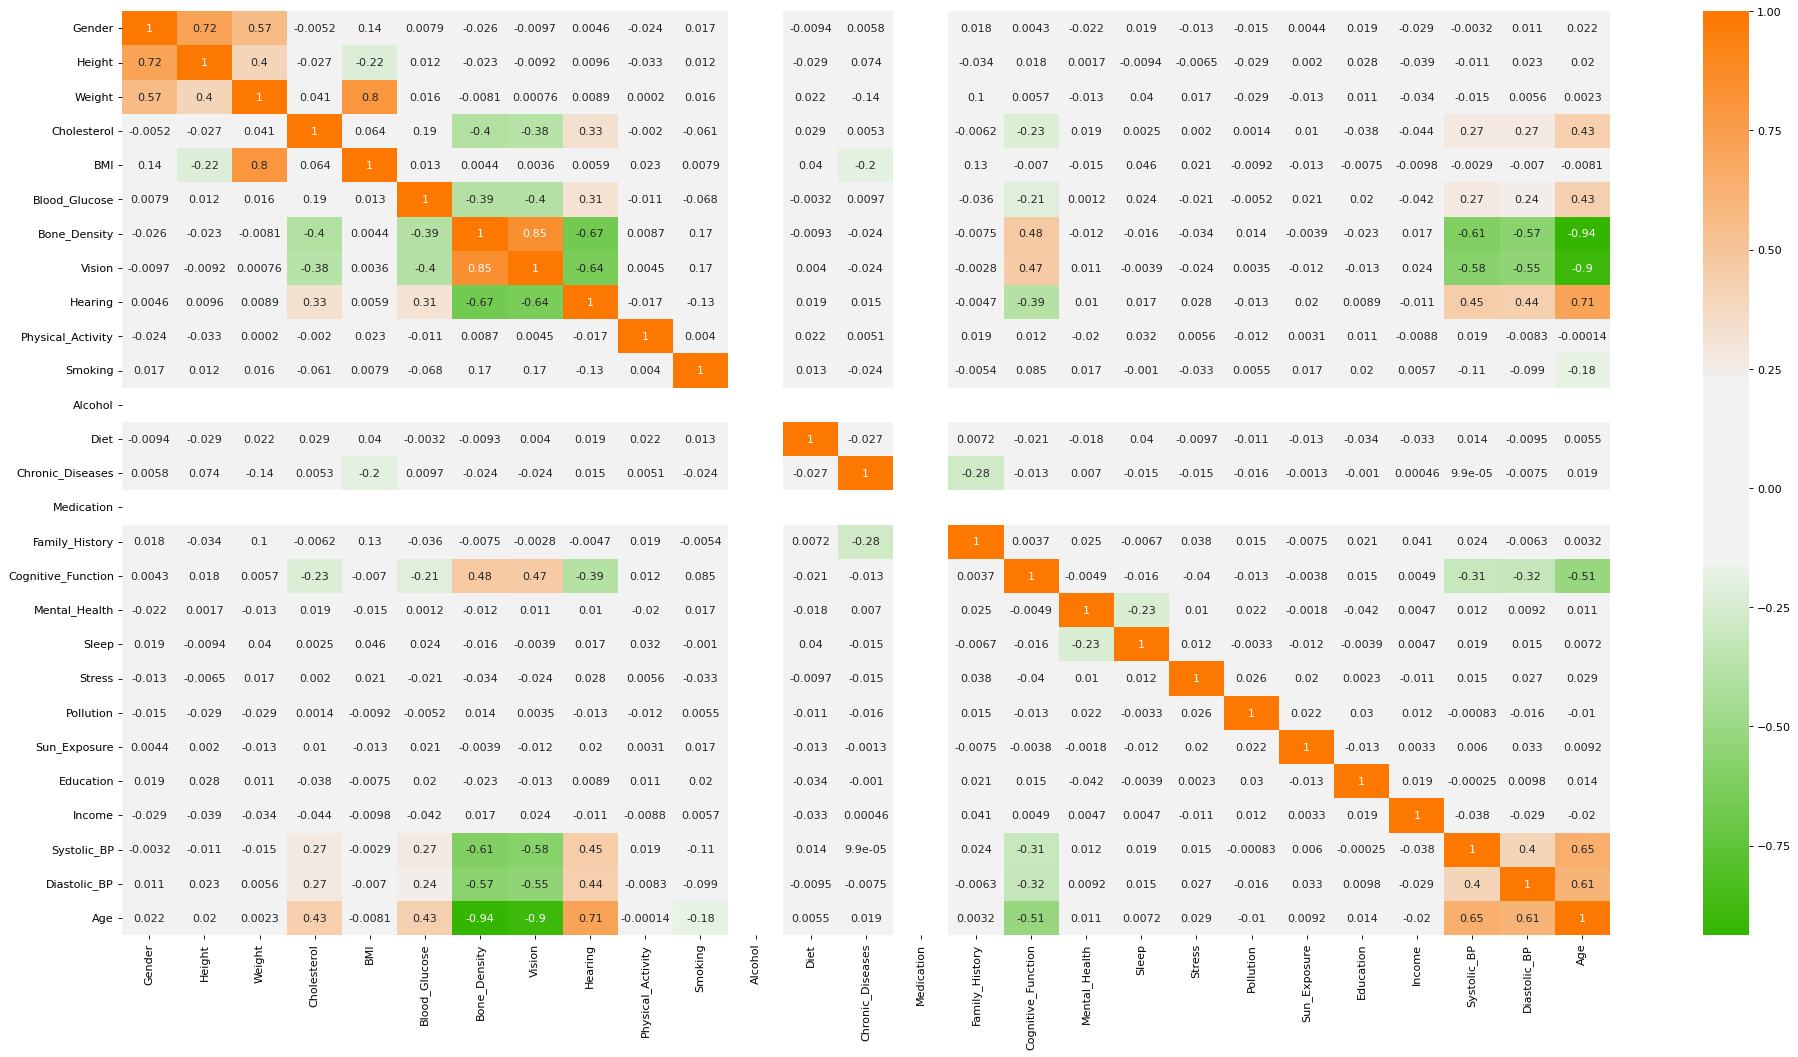

In [163]:
target = 'Age'
cmap = sns.diverging_palette(125, 28, s=100, l=65, sep=50, as_cmap=True)
fig, ax = plt.subplots(figsize=(30, 15), dpi=80)
ax = sns.heatmap(pd.concat([data2.drop(target,axis=1), data2[target]],axis=1).corr(), annot=True, cmap=cmap)
plt.show()

In [170]:
X2 = data2.drop('Age', axis=1)
y2 = data2['Age']

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2 ,test_size=0.2, random_state=0)

print("Train set: ", X_train.shape, y_train.shape)
print("Test set: ", X_test.shape, y_test.shape)

Train set:  (2400, 26) (2400,)
Test set:  (600, 26) (600,)


In [172]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [173]:
y_pred = model.predict(X_test)
y_pred.round()

array([40., 85., 65., 21., 61., 43., 79., 73., 51., 40., 33., 62., 51.,
       87., 30., 26., 25., 54., 74., 54., 33., 56., 33., 76., 61., 17.,
       41., 83., 64., 33., 62., 74., 40., 26., 68., 21., 52., 30., 44.,
       83., 34., 42., 38., 86., 82., 48., 37., 45., 51., 31., 46., 77.,
       51., 22., 37., 72., 78., 82., 24., 45., 52., 80., 71., 14., 15.,
       44., 73., 79., 27., 30., 41., 51., 82., 76., 69., 52., 43., 30.,
       82., 82., 39., 76., 45., 69., 50., 18., 78., 66., 38., 51., 43.,
       28., 62., 42., 48., 21., 52., 51., 61., 42., 29., 75., 66., 28.,
       69., 16., 68., 36., 59., 60., 46., 85., 72., 65., 51., 60., 79.,
       44., 50., 18., 36., 39., 53., 60., 72., 47., 21., 83., 45., 24.,
       48., 45., 40., 59., 49., 23., 68., 61., 80., 23., 48., 78., 37.,
       72., 68., 27., 74., 65., 85., 41., 67., 21., 41., 84., 49., 51.,
       64., 52., 79., 27., 50., 44., 47., 76., 34., 52., 59., 29., 52.,
       30., 79., 68., 46., 76., 68., 42., 42., 46., 26., 64., 27

In [174]:
y_test

311     45
1025    89
1587    60
2941    22
2980    71
2078    44
2281    78
720     78
1537    45
2493    41
1716    28
536     66
298     48
104     86
1649    36
2299    20
1109    29
899     52
461     81
2590    61
2664    23
983     62
1191    39
1003    78
2692    66
463     26
1108    50
305     86
1014    66
22      35
2770    63
1768    71
2277    42
1027    42
1476    80
762     20
30      62
1464    23
2132    53
1788    77
1410    27
977     46
961     38
306     81
569     80
156     52
2850    38
1244    46
2126    48
599     29
1351    46
1230    76
638     51
2053    19
615     34
2925    73
2160    88
722     89
2461    23
2460    36
2397    47
2785    88
2561    81
503     21
2083    18
905     46
1530    69
92      84
2411    25
1872    28
1999    43
1330    51
1255    88
2704    69
1217    70
898     58
483     44
1009    27
1682    83
1827    87
1246    40
485     80
643     41
2508    75
836     47
2619    20
910     67
686     70
1961    39
600     57
1917    44

In [175]:
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean squared error(MSE): ",mse)
print("Root mean squared error: ", rmse)
print("Mean absolute error: ", mae)
print("R2 score: ", r2)

Mean squared error(MSE):  26.854254188781717
Root mean squared error:  5.182109048329813
Mean absolute error:  4.097187586553672
R2 score:  0.9407868819366584
